# Disurption Index （仮・Colabではまだ正常に動きません）

※　ソースコードは順番に実行しないと正常に機能しない恐れがあります

## 概要

Disruption Index (Disruptiveness, Disruptive Index, D-index とも呼ばれる。以下 DI) は、Funk と Owen-Smith ([2017](https://pubsonline.informs.org/doi/abs/10.1287/mnsc.2015.2366)) によって経営工学で提唱されたものを Wu ら ([2019](https://www.nature.com/articles/s41586-019-0941-9)) が科学計量学に持ち込んだもので、革新性を「ある論文がそれ以前の文脈と断絶する度合い」と考え、断絶性を引用によって測った指標。

論文と特許について分析し、「すべての分野にわたって平均破壊スコアが継続的に低下している」と報告した Park ら ([2023](https://www.nature.com/articles/s41586-022-05543-x)) の論文は特に科学システムの内外に波紋を広げ、ここ数十年における（世界的な）科学システムの大幅な拡大にも関わらず、科学が勢いを失っているのかどうか、そしてなぜそのような問題を巡る世間の議論を引き起こすなど、DI に関する議論は社会的にも大きな関心を呼んだ。さらに多数の改良指標が提案されている。

一方で、時系列比較に意味がないなど複数の留意点があることが近年の分析 ([Leibel & Bornamnn 2024](https://link.springer.com/article/10.1007/s11192-023-04873-5)) からわかっており、使用する際には対象とするデータの特性や分析の目的に照らし合わせて、DI を使用することが適切か注意が必要である。


## なぜ Disruption Index を考えるのか

革新性を評価する多くの指標と同様に、DI は研究の重要度を測るために活用できる可能性を持った指標である。

### 政策への影響

研究は大きく漸進的 (Incremental) 研究と、革新的 (Disruptive) 研究があるとされており、漸進的研究に対しては計画が立てやすく、予算をつけ易い。一方で研究資金の配分を決定する際には革新的研究を適切に評価することで、新たな分野を開拓するような研究を捉えられれば研究競争力を大きく伸ばす可能性がある。

## Disruption Index 関連での重要論文

[What do we know about the disruption index in scientometrics? An overview of the literature](https://link.springer.com/article/10.1007/s11192-023-04873-5)

[Large teams develop and small teams disrupt science and technology](https://www.nature.com/articles/s41586-019-0941-9)

[Papers and patents are becoming less disruptive over time](https://www.nature.com/articles/s41586-022-05543-x)

## Disruption Index の定義

![D definition](./supplementary/D_def.png)
![D example](./supplementary/D_example.png)

([Wu et al. 2019](https://www.nature.com/articles/s41586-019-0941-9))


In [ ]:
%pip install pyalex


In [5]:
from scipy import stats
import numpy as np
import pandas as pd
from pyalex import Works
import pickle
import time
import random
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.axes_grid1 import host_subplot

DATA_DIR = '/disks/qnap2/data/t-yatima/scisciJP2024_tutorial/'
INPUT_WORKS_DF_PKL = DATA_DIR + 'random_works_small_df.pkl'
INPUT_CITATIONS_DF_PKL = DATA_DIR + 'random_rel_ref_small_df.pkl'
INPUT_WU_WORKS_LIST_SMALL_PKL = DATA_DIR + 'teamsize_impact_disrup_refAge_refPop_small.pkl'
import sys

In [ ]:

# colabで実行する時のためのコード
import sys
import os

%cd /content/sample_data/
!git clone https://github.com/ScisciJP/scisciJP2024_tutorial.git

sys.path.append('/content/sample_data/scisciJP2024_tutorial')
print(os.getcwd())
os.chdir('/content/sample_data/scisciJP2024_tutorial')
sys.path

DATA_DIR = '/content/sample_data/scisciJP2024_tutorial/supplementary/'
INPUT_WORKS_DF_PKL = DATA_DIR + 'random_works_small_df.pkl'
INPUT_CITATIONS_DF_PKL = DATA_DIR + 'random_rel_ref_small_df.pkl'
INPUT_WU_WORKS_LIST_SMALL_PKL = DATA_DIR + 'teamsize_impact_disrup_refAge_refPop_small.pkl'

In [2]:
# 必要なデータの読み込み、準備
works_df = pd.read_pickle(INPUT_WORKS_DF_PKL)
citations_df = pd.read_pickle(INPUT_CITATIONS_DF_PKL)
W = pickle.load(open(INPUT_WU_WORKS_LIST_SMALL_PKL, 'rb'))
def citation_groupby(df_citation):
    citations_source_gp = df_citation.groupby('source').agg(list)
    citations_target_gp = df_citation.groupby('target').agg(list)
    df_citation_gp = pd.concat([citations_source_gp,citations_target_gp],axis = 1)
    return df_citation_gp
citations_gb = citation_groupby(citations_df)
display(works_df[:3], len(works_df), citations_df[:3], len(citations_df), citations_gb[citations_gb['source'].notna()][:3], len(citations_gb), W[:3], len(W))

,JournalId,Year,NumberCitations,Title,Date,DocType,Doi,PMID,Volume,Issue,FirstPage,LastPage,IsRetracted,IsParaText,AuthorCount
PublicationId,,,,,,,,,,,,,,,
2170866237,NaN,1988,2,Testing Safety Assessment Models Using Natural...,1988-01-01,article,10.1557/proc-127-863,NaN,NaN,NaN,NaN,NaN,False,False,5.0
1982793646,NaN,1989,7,Design Procedures for Fiber Composite Box Beams,1989-07-01,article,10.1177/073168448900800404,NaN,8,4,370,397,False,False,2.0
2013241878,NaN,1970,1900,Viral RNA-dependent DNA Polymerase: RNA-depend...,1970-06-01,article,10.1038/2261209a0,4316300,226,5252,1209,1211,False,False,1.0


1172

,source,target
0,2082805732,2069814472
1,1461953811,2093032015
2,3177720207,2126466006


4882918

,target,source
7932595,[2093985390],"[2075733422, 897970311, 2168728020, 1790939485..."
16221063,"[1492323218, 2086944812, 3123691218]","[2043634402, 2082863451, 1964406220, 206718778..."
22148887,"[1970544711, 1988297114, 2068896862, 2135404743]","[3148334029, 2799668922, 4313589916, 222948779..."


3830916

[[7, 1, 0.0005817335660267597, 8.0, 114.0],
 [3, 2, -0.000461361014994233, 15.0, 234.5],
 [3, 254, -0.021009362868234755, 3.77419354839, 117.0]]

1000000

## ネットワークの可視化


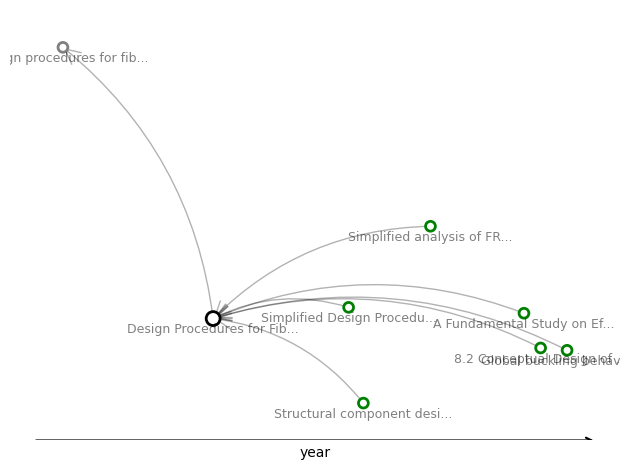

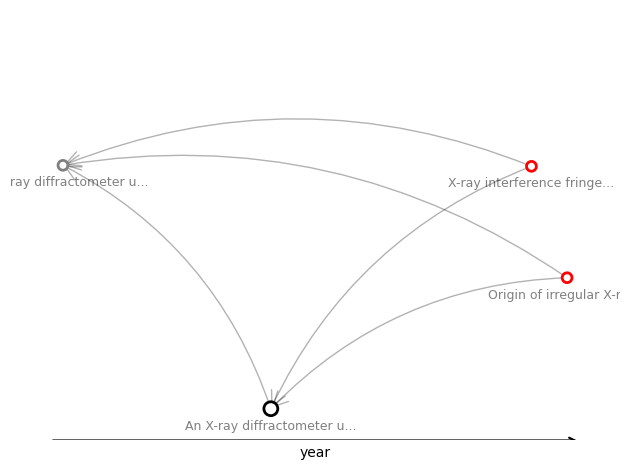

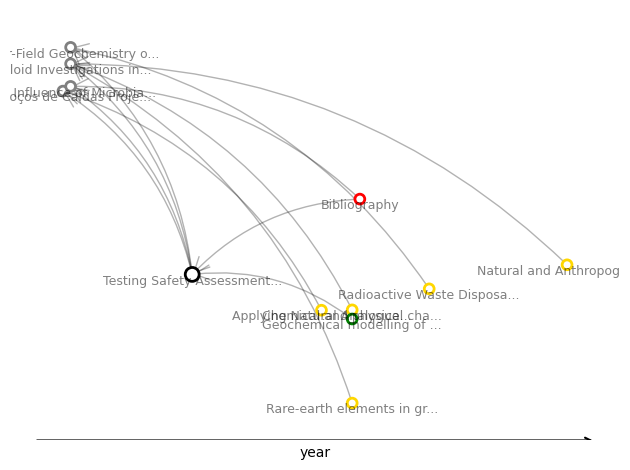

In [3]:
# いい感じにネットワークを表示する
def get_nodetypes(c, s, t):
    nodes_b = set(c) & set(s) 
    nodes_f = set(c) - set(s)
    nodes_r = set(s) - set(c) - set(t)
    return nodes_b, nodes_f, nodes_r

def draw_network(ID):
    works_target = citations_df[citations_df["source"]==ID]
    works_source = citations_df[citations_df["target"].isin(works_target["target"].values)]
    works_citing = citations_df[citations_df["target"]==ID]

    edges = [tuple(row) for _, row in works_source[["source","target"]].iterrows()] + [tuple(row) for _, row in works_citing[["source","target"]].iterrows()]
    nodes = set([item for sublist in edges for item in sublist])

    node_detail = None
    for id in nodes:
        node_detail = pd.concat([node_detail,pd.DataFrame(Works().filter(ids={"openalex":"W"+str(id)}).select(["title","publication_date"]).get(), index=[id])])
    node_detail = node_detail.fillna(value={"title": "No title"})

    node_detail["unix_time"] = node_detail["publication_date"].apply(lambda t: int(time.mktime(time.strptime(t, "%Y-%m-%d"))))
    node_detail["date_diff"] = node_detail["unix_time"] - node_detail.loc[ID, "unix_time"]

    nodes_b, nodes_f, nodes_r = get_nodetypes(works_citing["source"].unique(), works_source["source"].unique(),works_target["target"].unique())

    node_detail.loc[list(nodes_b), "type"] = 1
    node_detail.loc[list(nodes_f), "type"] = 2 
    node_detail.loc[list(nodes_r), "type"] = 3
    node_detail = node_detail.fillna({"type": -1})

    node_detail.loc[ID, "type"] = 0

    color = ["black", "red","green","gold","grey"]
    node_detail["color"] = node_detail["type"].apply(lambda x: color[int(x)])
    node_detail["ypos"] = -(node_detail["type"]-2)*15+np.array([(random.random()-0.5)*50 for _ in range(len(node_detail))])
    node_detail.loc[ID, "ypos"] = 0
    node_detail["xpos"] = node_detail["date_diff"]/10000000 +50*np.sign(node_detail["type"])
    node_detail.loc[ID, "xpos"] = 0
    node_detail["size"] = 50
    node_detail.loc[ID, "size"] = 100

    G = nx.DiGraph()

    G.add_edges_from(edges)
    nodes_pos = {v:(node_detail.loc[v,"xpos"],node_detail.loc[v,"ypos"]) for v in node_detail.index}
    max_length = 25  # Maximum length of the title
    node_labels = {node: node_detail.loc[node, 'title'][:max_length] + "..." if len(node_detail.loc[node, 'title']) > max_length else node_detail.loc[node, 'title'] for node in G.nodes()}
    label_pos = {v:(node_detail.loc[v,"xpos"],node_detail.loc[v,"ypos"]-2) for v in node_detail.index}

    node_colors = [node_detail.loc[node,'color'] for node in G.nodes()]
    node_sizes = [node_detail.loc[node,'size'] for node in G.nodes()]

    nx.draw_networkx_edges(G,nodes_pos, arrows=True,node_size=2, connectionstyle="arc3, rad=0.2", arrowstyle="->", alpha= 0.3, arrowsize=27)
    nx.draw_networkx_labels(G, pos=label_pos, labels=node_labels, font_size=9, alpha=0.5)
    nx.draw_networkx_nodes(G, nodes_pos, node_size=node_sizes, node_shape='o',edgecolors=node_colors,node_color="white",linewidths=2, alpha= 1)
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    arrow = FancyArrowPatch((x_min+10, y_min), (x_max-10, y_min),
                        arrowstyle='->', mutation_scale=10,
                        linewidth=1.5, color='black')
    ax = plt.gca()
    ax.add_patch(arrow)
    plt.xlabel("year")
    ax = plt.gca() 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.show()
    plt.close()

# 見やすさのために、参考文献数の少ない論文を表示しています
draw_network(1982793646)
draw_network(2127548443)
draw_network(2170866237)

## データの分布

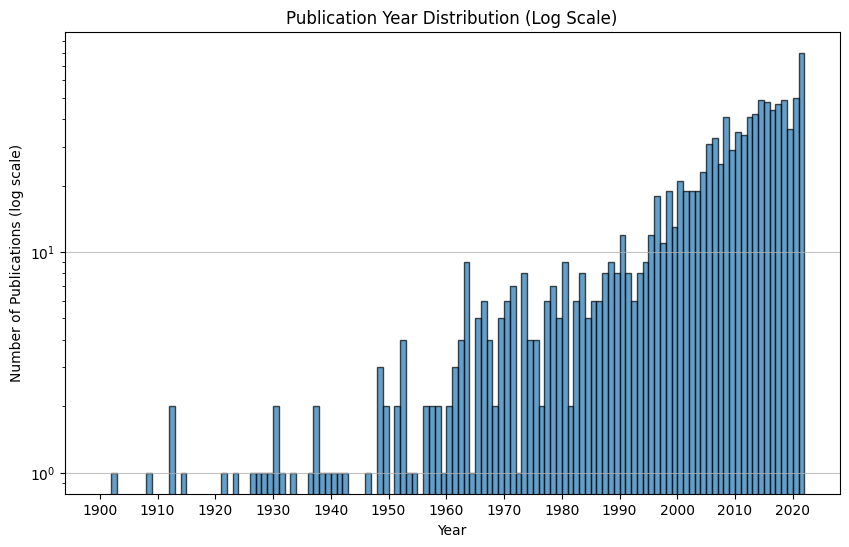

In [4]:
# 年ごとの論文数の分布
plt.figure(figsize=(10, 6))
plt.hist(works_df['Year'], bins=range(1900, 2023), edgecolor='black', alpha=0.7, log=True)
plt.title("Publication Year Distribution (Log Scale)")
plt.xlabel("Year")
plt.ylabel("Number of Publications (log scale)")
plt.xticks(range(1900, 2023, 10))
plt.grid(axis='y', alpha=0.75)
plt.show()

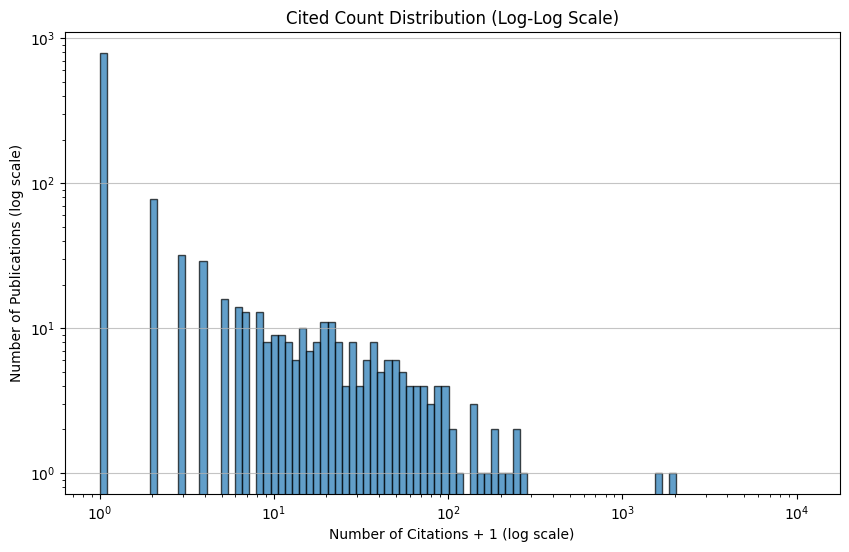

In [5]:
# 対数スケールでのビンのエッジを生成
bins = np.logspace(np.log10(min(works_df['NumberCitations']+1)), np.log10(max(works_df['NumberCitations']+1)), 100)

# 被引用数ごとの論文数の分布
plt.figure(figsize=(10, 6))
plt.hist(works_df['NumberCitations']+1, bins=bins, edgecolor='black', alpha=0.7, log=True)
plt.title("Cited Count Distribution (Log-Log Scale)")
plt.xlabel("Number of Citations + 1 (log scale)")
plt.ylabel("Number of Publications (log scale)")
plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Disruption Indexの計算

In [6]:
flatten = lambda l: [item for sublist in l if sublist == sublist for item in sublist]

def get_score(node):
    try:
        node_r = set(citations_gb.target.loc[node])
        node_r_c = set(flatten([citations_gb.source.loc[x] for x in node_r])) - set([node])
        node_c = set(citations_gb.source.loc[node])
        allnodes = node_c | node_r_c
        cite_target = node_c - node_r_c
        cite_targetref = node_r_c - node_c
        cite_target_targetref_both = node_r_c & node_c
        score = (len(cite_target)*1 + len(cite_target_targetref_both)*-1 + len(cite_targetref)*0)/len(allnodes)
        return score
    except:
        return None

In [7]:
eids = works_df.index

res = []
for n, eid in enumerate(eids):
    if n % 5000 == 0: print(f'{n} / {len(works_df)}')
    res.append(get_score(eid))
scores = pd.DataFrame([[eid,re] for eid,re in zip(eids,res)])

scores.index = scores[0]
# scores['team_size'] = scores[0].map(works_df['AuthorCount'])
scores = scores[~scores[1].isna()].drop(columns=0).rename(columns={1: 'disruption'})
display(scores)

0 / 1172


,disruption
0,
2170866237,0.000000
1982793646,1.000000
2013241878,-0.408429
2126466006,0.957852
2127548443,-1.000000
...,...
2034475130,0.009371
2129436324,0.000586
2090206302,0.001835


## DIの分布

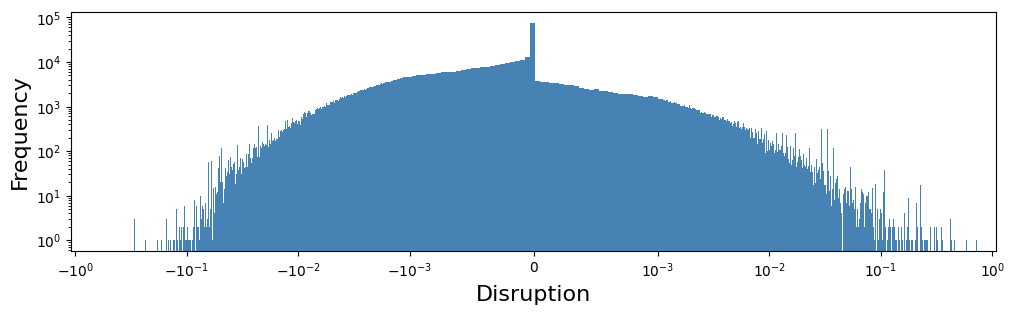

In [8]:
D = [row[2] for row in W]

nbins=50000
fig = plt.figure(figsize=(10, 3),facecolor='white')
ax = fig.add_subplot(111)
#
N, bins, patches = ax.hist(D, bins=nbins,edgecolor='white', linewidth=0)
LN=np.log(max(N))


# Find fractions of small natural denominator and make them less distractive
delta=bins[1]-bins[0]
peaks=set([j/i for i in range(1,100) for j in range(1,i)]+\
[-j/i for i in range(1,100) for j in range(1,i)]) 
ys=dict((i,(patches[i-1]._height+patches[i+1]._height)*0.5) \
        for i in range(1,len(N)-2)) #smooth color

for i,z in zip(range(0,nbins),bins):
    if patches[i]._height>0: # only plot patches with values
        r=(np.log(patches[i]._height)/LN)**5 # transparency scales to y values
        for p in peaks:
            if z<p<z+delta and 0<i<len(N):
                r=(np.log(ys[i]+1)/LN)**5 # disruption fraction
        patches[i].set_alpha(1)
        patches[i].set_facecolor(color='SteelBlue')

plt.yscale('log')
plt.xscale('symlog',linthresh=0.001)
plt.tight_layout()
plt.xlabel('Disruption',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.show()

## チームサイズとの関係

In [3]:
teamsize, impact, disruption, referenceAge, referencePopularity = np.array(W).T

#aggregate data by team size
impPaper=defaultdict(lambda:[])
disPaper=defaultdict(lambda:[])
for ts,imp,disrupt,refAge, refPop in W:
    if 1<=ts<=10:
        impPaper[ts].append(imp)
        disPaper[ts].append(disrupt)

DisruptionPaper=random.sample(list(disruption),10000)

69.805

In [6]:
# calculate CI using bootstrap
def calculateCI(dic,method,n):
    ci=[]
    for teamsize in range(1,11):
        data=dic[teamsize]
        m=int(len(data)/10) #take 10% data
        ms=[]
        for j in range(n): #number of samples
            if method=='mean':
                    ms.append(np.mean(np.random.choice(data,m)))
            if method=='median':
                    ms.append(np.median(np.random.choice(data,m)))
        a,b=[np.percentile(ms,2.5),np.percentile(ms,97.5)]
        ci.append([a,b])
    a,b=np.array(ci).T
    return a,b

# mean
xdisPaper,ydisPaper=np.array(sorted([(k,np.mean(v)) for k,v in disPaper.items()])).T
ximpPaper,yimpPaper=np.array(sorted([(k,np.mean(v)) for k,v in impPaper.items()])).T
# CI
ydisPaperCIa,ydisPaperCIb=calculateCI(disPaper,'mean',50)
yimpPaperCIa,yimpPaperCIb=calculateCI(impPaper,'mean',50)
#percentile
ydisPaper=[stats.percentileofscore(DisruptionPaper,i) for i in ydisPaper]
ydisPaperCIa=[stats.percentileofscore(DisruptionPaper,i) for i in ydisPaperCIa]
ydisPaperCIb=[stats.percentileofscore(DisruptionPaper,i) for i in ydisPaperCIb]

10_49

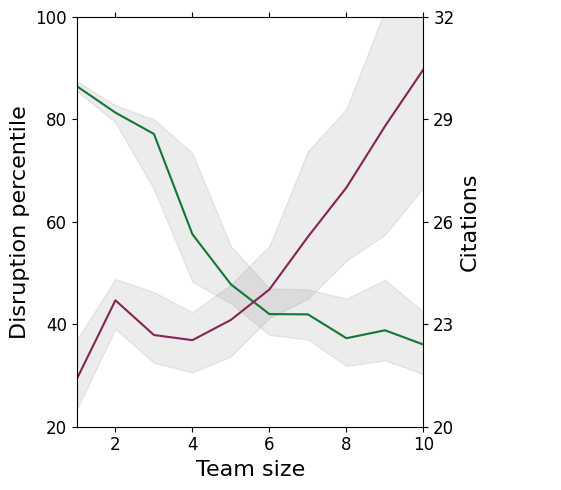

In [7]:
fig = plt.figure(figsize=(5,5),facecolor='white')

host = host_subplot(111)
plt.subplots_adjust(right=1)
host.tick_params(axis='x', which='both',bottom='on',top='off')
par1 = host.twinx()

host.plot(xdisPaper,ydisPaper, label="Disruption",color='#117733')
par1.plot(ximpPaper,yimpPaper, label="Impact",color='#882255')
host.fill_between(range(1,11), ydisPaperCIa,ydisPaperCIb,color='gray',alpha=0.15)
par1.fill_between(range(1,11), yimpPaperCIa,yimpPaperCIb,color='gray',alpha=0.15)

host.set_xlim(1, 10)
host.set_ylim(20,100)
host.set_yticks([20,40,60,80,100])
par1.set_ylim(20,32)
par1.set_yticks([20,23,26,29,32])
host.set_xlabel('Team size',size=16)
host.set_ylabel('Disruption percentile',size=16)
par1.set_ylabel('Citations',size=16)
host.tick_params(axis='both', which='major', labelsize=12)
par1.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

### 被引用数で分割した場合

In [8]:
DisImpact=defaultdict(lambda:defaultdict(lambda:[]))
for teamsize,impact,disruption,referenceAge, referencePopularity in W:
    if 1<=teamsize<=10 and impact>0:
        if impact<=1:
            ilevel=1
        if 1<impact<10:
            ilevel=2
        if 10<=impact<24:
            ilevel=3           
        if 24<=impact<52:
            ilevel=4           
        if 52<=impact<84:
            ilevel=5
        if impact>=84:
            ilevel=6
        DisImpact[ilevel][teamsize].append(disruption)

disImpact={}
disImpact1={}
for ilevel in [1,2,3,4,5,6]:
    disImpact[ilevel]=sorted([(k,stats.percentileofscore(DisruptionPaper, np.mean(v)))\
                                   for k,v in DisImpact[ilevel].items()])
    disImpact1[ilevel]=sorted([(k,np.mean(v)) for k,v in DisImpact[ilevel].items()])

/tmp/ipykernel_1102298/1894785837.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = cm.get_cmap('summer_r',7)


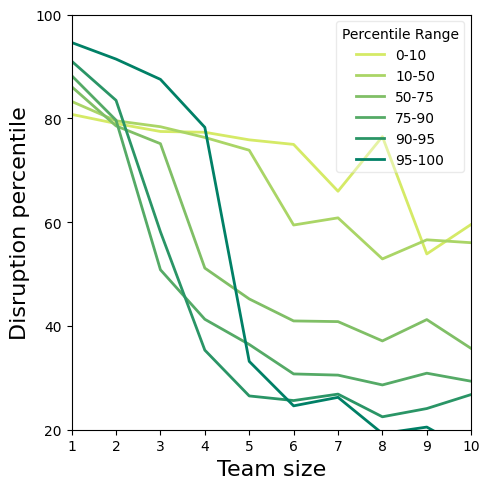

In [22]:
fig = plt.figure(figsize=(5,5),facecolor='white')
cmap1 = cm.get_cmap('summer_r',7)
ax = fig.add_subplot(111)
ip = {1: '0-10', 2: '10-50', 3: '50-75', 4: '75-90', 5: '90-95', 6: '95-100'}
for ilevel in [1, 2, 3, 4, 5, 6]:
    x, y = np.array(disImpact[ilevel]).T
    plt.plot(x, y, color=cmap1(ilevel), linewidth=2, alpha=1, label=ip[ilevel])
ax.set_xlim(1,10)
ax.set_ylim(20,100)
ax.set_yticks([20, 40, 60, 80, 100])
plt.xlabel('Team size',fontsize=16)
plt.ylabel('Disruption percentile',fontsize=16)

plt.legend(title='Percentile Range', loc='upper right', framealpha=0.4)
plt.tight_layout()
plt.tight_layout()

## 高DI/低DI論文の例

In [10]:
def show_paper(id):
    display(scores[scores.index == id].merge(pd.DataFrame({'authors': str([authorship['author']['display_name'] for authorship in Works().filter(ids={"openalex":"W"+str(id)}).select(["authorships"]).get()[0]['authorships']])}, index=[id]), left_index=True, right_index=True).merge(works_df, left_index=True, right_index=True).drop(columns=['JournalId', 'Year']))
show_paper(2126466006)
show_paper(2013241878)

NameError: name 'scores' is not defined

## Disruption Indexの利用 - 他の研究指標の関係

DIを用いて、研究の様々な変数と革新性との関連をみた研究を紹介する。ただし、一部の研究成果は#Disruption Indexの制約と限界の項で話すような点を考慮すると解釈が変わる可能性があり、結果は慎重に分析した上で受容する必要がある。

### チームサイエンス（共著）

小規模なチームほど革新性、大規模なチームほどインパクト（＝引用数）が大きい ([Wu et al. 2019](https://www.nature.com/articles/s41586-019-0941-9))

### 分野別の成果

放射線医学 ([Abu-Omar et al. 2022](https://www.sciencedirect.com/science/article/abs/pii/S000992602200335X))、外科医学 ([Becerra et al. 2021](https://www.americanjournalofsurgery.com/article/S0002-9610(20)30501-8/abstract))、眼科 ([Patal et al. 2022](https://escholarship.org/uc/item/76s934s0)) ほか

エネルギー安全保障分野 ([Jiang et al. 2023](https://www.mdpi.com/2071-1050/15/2/969))

ナノ科学 ([Kong et al. 2023](https://link.springer.com/chapter/10.1007/978-3-031-34668-2_6))

### 引用数など、他の指標との関連

ノーベル賞受賞論文の平均DIは全論文でトップ2%のDIに相当する ([Wu et al. 2019](https://www.nature.com/articles/s41586-019-0941-9))

ノーベル賞受賞論文を引用、被引用している論文は多くがDIが正 ([Yang et al 2023](https://www.sciencedirect.com/science/article/abs/pii/S0306457323001577))

Journal Impact Factorsの代替として ([Jiang et al. 2023](https://link.springer.com/article/10.1007/s11192-023-04737-y))

### 時間的変化

第二次世界大戦以降、学術論文や特許全体で次第にDisruptionが下がり続けている ([Park et al. 2023](https://www.nature.com/articles/s41586-022-05543-x))

## Disruption Indexの制約と限界

DIはNoveltyなどの他の指標と比べても、対象とする論文とその引用ネットワーク上での親子のみを使えば対象論文については出るため測りやすく使いやすい一方、いくつかの点で注意が必要であることが指摘されている。

一般に、指標は可操作化する概念以外のいかなるパラメターとも関連しないはずであり、その概念に関係のないパラメター影響している場合は、その指標がバイアスを持っていると言える。例えばDIにおいては、"disruption and consolidation"に関係のない変数がDIに影響している場合は、DIはバイアスのある指標だと言える。

DIによる分析の注意点については、Leibel と Bornamnn ([2024](https://link.springer.com/article/10.1007/s11192-023-04873-5)) による総説論文を参照すること。

- 引用データそのものに内在するバイアス - 引用データは完全ではなく、多くの欠損を含む。例えば、自然科学に比して社会学、人文学では出版物の総量に対して書誌データベースによってインデックスされた文献の量が遥かに少ないことが知られており ([Bornmann 2020](https://direct.mit.edu/qss/article/1/3/1242/96102/Are-disruption-index-indicators-convergently-valid))、書籍や非英語文献の再録が十分でない。また、引用は多く修辞的であり、着想に影響を与えた論文のみが引用されているとは限らず、引用のネットワークはノイズが大きい ([Tahamtan and Bornmann 2018](https://www.sciencedirect.com/science/article/abs/pii/S1751157718302219))。例えば、Ruan ら ([2021](https://www.sciencedirect.com/science/article/abs/pii/S0040162521005035)) の報告で社会科学、CSSCI（中国社会科学引用指数）に再録の論文では $DI=1$ の論文割合がそれぞれ3.1%, 27.5%と高く出る（経営学、工学、数学、神経科学、植物科学などの分野では2%未満）のは、書誌データベースに引用情報が登録されておらず $N_{f} = N_{b} = 0$ の場合を多く含むからである。したがって古い文献についてもDIは正確に算出できない（多くの場合1になる）。したがって、社説、Letter、書評、会議抄録などは雑誌論文との比較をしてはならない。

- 参照FPを引用していない論文によるDIへの影響に一貫性がない ([Wu and Wu 2019](https://osf.io/preprints/socarxiv/d3wpk)) - $N_{r}$ はConsolidatingな要素であるから、常にDisruptivenessを下げる方へ働くはずだが、 $N_{f} - N_{b}$ が負の時、 $N_{r}$ が増加するとDisruptivenessは増加する。

- 経時バイアス、安定するまで時間がかかる ([Bornmann and Tekles 2019](https://revista.profesionaldelainformacion.com/index.php/EPI/article/view/epi.2019.mar.07)) - 論文がどの程度の期間にわたって新しい引用を獲得するかは論文間で大きく異なり、結果としてDisruptivenessの値が安定するまでも同様に時間がかかり、少なくとも出版から5年、長くて20年ほどが必要となる。

- FPが引用する文献の被引用数に依存するバイアス ([Liu et al. 2023](https://www.sciencedirect.com/science/article/abs/pii/S1751157723000573)) - FPが被引用数の高い論文を引用しているときには、その文献を引用している文献の数が増える傾向にあるので、DIは低下しやすい。一例として、Ke et al. ([2015](https://www.pnas.org/doi/abs/10.1073/pnas.1424329112)) の引用文献から有名なvan Raan ([2004](https://akjournals.com/view/journals/11192/59/3/article-p467.xml)) (被引用数789) の論文を削除するだけで、DIは-0.54から-0.18に増加する。

- FPが引用する文献数バイアス ([Ruan et al. 2021](https://www.sciencedirect.com/science/article/abs/pii/S0040162521005035)) - 同様の理由から、FPが引用している文献数が増えるほど、その文献を引用している文献の数が増える傾向にあるので、DIは低下しやすい。総説論文は原著論文に比べDIが低く出る。ただし、10件以上の引用文献がある論文に絞ると正の相関があるとの報告もある。

## 総論 - Disruption Indexの利用可能性

以上の制約を考慮した上でも、DIは利用の幅の広い指標である。

総論としては、DIを使用する際には以下の項目を揃える必要がある：文書形式（原著論文、社説、書評など）、言語、分野、出版からの経過年。また、引用文献データを十分に再録できていないと思われるデータとして、非常に古いデータ（一つの目安として、1960年以前の論文には注意が必要である）や非常に若いデータを削除すること。

また、引用数が少ない文献は非常に不安定な結果を生むため、引用数、被引用数が一定以上の文献を対象とすべきである。慣行としては10以上とすることが多い。

